In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod
import torch
import torch.nn.functional as F


from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from MogrifierLSTM import MogrifierLSTMCell
from utils.dataset import NCDFDatasets
from utils.evaluator import Evaluator
from utils.trainer import Trainer
from datetime import datetime
from gridmask import GridMask
from evonorm import EvoNorm3D

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

In [4]:
batch_size = 25
validation_split = 0.2
test_split = 0.2
dropout_rate = 0.2
hidden_size = 2500
mogrify_rounds = 5
prediction_window=5
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}

grid_mask_param = {'ratio':0.4, 'max_prob': 1, 'd1':3, 'd2': 20, 'max_epochs': 10}

In [5]:
import xarray as xr
data_path = '../../../data/dataset-chirps-1981-2019-seq5-ystep5.nc'
dataset = xr.open_dataset(data_path)
print(dataset)

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 50, lon: 50, sample: 13960, time: 5)
Coordinates:
  * lat      (lat) int64 -39 -38 -37 -36 -35 -34 -33 -32 ... 3 4 5 6 7 8 9 10
  * lon      (lon) int64 -84 -83 -82 -81 -80 -79 -78 ... -40 -39 -38 -37 -36 -35
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have preciptation values and are separable in...


In [6]:
#In these experiments y has dimensions [batch, channel, lat, lon] as opposed to [batch, channel, time, lat, lon] to
#avoid dimension conflict with conv kernels
data = NCDFDatasets(dataset, val_split = 0.2, test_split = 0.2)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [7]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)

-----Train-----
X :  torch.Size([8376, 1, 5, 50, 50])
Y :  torch.Size([8376, 1, 5, 50, 50])
-----Val-----
X :  torch.Size([2792, 1, 5, 50, 50])
Y :  torch.Size([2792, 1, 5, 50, 50])
-----Test-----
X :  torch.Size([2792, 1, 5, 50, 50])
Y :  torch.Size([2792, 1, 5, 50, 50])


In [8]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

def init_seed(seed):
    np.random.seed(seed)
    
init_seed = init_seed(seed)

In [9]:
params = {'batch_size': batch_size,
          'num_workers': 4,
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

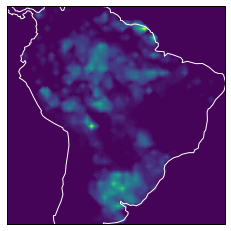

In [10]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = train_data.y[0, 0, 0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

In [11]:
class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [12]:
class CustomConv3d(torch.nn.Conv3d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1,
                 bias=False, padding_mode='zeros', weight=None):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride,
                 padding=padding, dilation=dilation,
                 bias=bias, padding_mode=padding_mode)
        
    def forward(self,input, weight=None):
        if (weight is not None):
            return F.conv3d(input, weight.permute(1,0,2,3,4), self.bias, self.stride,
                        self.padding, self.dilation)
        else:
            return F.conv3d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation)

In [13]:
class EncoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels, device):
        super(EncoderCNN, self).__init__()
        self.device = device
        self.layer_size = layer_size
        self.conv_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.decode_bn_layers = torch.nn.ModuleList()
        self.dropout_layers = torch.nn.ModuleList()
        
        self.kernel_size = [1, kernel_size, kernel_size]
        self.padding = [0, kernel_size // 2, kernel_size // 2]
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        for i in range(self.layer_size):
            self.conv_layers.append(CustomConv3d(in_channels = in_channels, out_channels = out_channels,
                                                padding = self.padding, kernel_size = self.kernel_size))
            self.bn_layers.append(EvoNorm3D(out_channels, version = 'B0_3D'))
            self.dropout_layers.append(torch.nn.Dropout(dropout_rate))
            self.decode_bn_layers.append(EvoNorm3D(out_channels, version = 'B0_3D'))
            in_channels = out_channels
        self.conv_reduce = CustomConv3d(in_channels = in_channels, out_channels = 1,
                                                kernel_size = 1)
            
            
    def forward(self, x, decode=False):
        if (decode):
            x = self.conv_reduce(x, self.conv_reduce.weight)
            for i in range(self.layer_size-1, -1, -1):
                x = self.decode_bn_layers[i](x)
                x = self.dropout_layers[i](x)
                x = self.conv_layers[i](x, self.conv_layers[i].weight)
        else:
            for i in range(self.layer_size):
                x = self.conv_layers[i](x)
                x = self.bn_layers[i](x)
                x = self.dropout_layers[i](x)
            x = self.conv_reduce(x)
        return x

In [14]:
class STModel(torch.nn.Module):
    def __init__(self, encoder_layer_size, decoder_layer_size, kernel_size, out_channels, in_channels, input_width, input_height, hidden_size,
                prediction_window, device):
        super(STModel, self).__init__()
        self.device = device
        self.prediction_window = prediction_window
        self.encoder = EncoderCNN(layer_size = encoder_layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, device=device)
        self.recurrent_encoder = torch.nn.LSTMCell(input_width*input_height, hidden_size);
        #self.recurrent_decoder = torch.nn.LSTMCell(input_width*input_height, hidden_size);
       
        
    def forward(self, x, states):
        batch, channel, time, lat, lon = x.size()
        x = self.encoder(x)
        
        x = x.squeeze().view(batch, time, -1)
        h = states[0]
        c = states[1]
        for i in range(time):
            h,c = self.recurrent_encoder(x[:,i,:],(h,c))
            
        outputs = torch.zeros(batch, self.prediction_window, lat*lon, device=self.device)    
        inputLSTM = torch.zeros(h.size(), device=self.device)
        for i in range(self.prediction_window):
            h,c = self.recurrent_encoder(inputLSTM,(h,c))
            inputLSTM = h
            outputs[:,i,:] = h
            
        x = outputs.contiguous().view(batch, channel, self.prediction_window, lat, lon)
        x = self.encoder(x, decode=True)
        return x
        

In [15]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss


In [16]:
model = STModel(encoder_layer_size = param['encoder_layer_size'], decoder_layer_size = param['decoder_layer_size']
                ,kernel_size = param['kernel_size'], out_channels = param['filter_size'],
                in_channels = train_data.x.shape[1], input_width = train_data.x.shape[3], 
                input_height = train_data.x.shape[4], hidden_size = hidden_size, 
                prediction_window = prediction_window, device=device).to(device)
criterion = torch.nn.L1Loss()
#optimizer_params = {'lr': 0.001}
#optimizer = torch.optim.Adam(net.parameters(), **optimizer_params)
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)
model

STModel(
  (encoder): EncoderCNN(
    (conv_layers): ModuleList(
      (0): CustomConv3d(1, 32, kernel_size=[1, 5, 5], stride=(1, 1, 1), padding=[0, 2, 2], bias=False)
      (1): CustomConv3d(32, 32, kernel_size=[1, 5, 5], stride=(1, 1, 1), padding=[0, 2, 2], bias=False)
      (2): CustomConv3d(32, 32, kernel_size=[1, 5, 5], stride=(1, 1, 1), padding=[0, 2, 2], bias=False)
    )
    (bn_layers): ModuleList(
      (0): EvoNorm3D()
      (1): EvoNorm3D()
      (2): EvoNorm3D()
    )
    (decode_bn_layers): ModuleList(
      (0): EvoNorm3D()
      (1): EvoNorm3D()
      (2): EvoNorm3D()
    )
    (dropout_layers): ModuleList(
      (0): Dropout(p=0.2, inplace=False)
      (1): Dropout(p=0.2, inplace=False)
      (2): Dropout(p=0.2, inplace=False)
    )
    (conv_reduce): CustomConv3d(32, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  )
  (recurrent_encoder): LSTMCell(2500, 2500)
)

In [17]:
model_path = os.path.join('../../../models/CHIRPS/5_step/STTSModel_3D_GridMask_MAE' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, model_path, recurrent_model= True, grid_mask = grid_mask_param)


In [19]:
train_losses, val_losses = trainer.train_evaluate()

1


KeyboardInterrupt: 

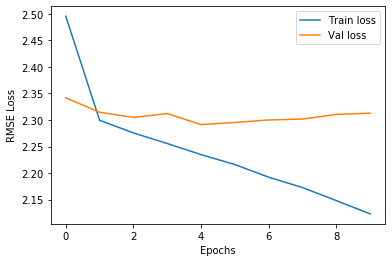

In [20]:
epochs = np.arange(1,len(val_losses))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

In [18]:
model, optimizer, epoch, loss = trainer.load_model()
iter_test_loss = 0.0
model.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        states = trainer.init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        loss = criterion(output, y)
        iter_test_loss += loss.detach().item()
test_loss = iter_test_loss/len(test_loader)
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S L1Loss: 2.3110


In [21]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
def report_regression_results(y_true, y_pred):
    # Print multiple regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    adjusted_r2 =  1.0 - ( mse / y_true.var() )
    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('Adjusted r2: ', round(adjusted_r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    # save a plot with the residuals
    plt.scatter(y_pred,(y_true - y_pred),edgecolors='black')
    plt.title('Fitted vs. residuals plot')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()
    f.savefig("report-experiment1.pdf", bbox_inches='tight')
    
def report_explained_variance(y_true, y_pred):
    batch, ch, time, lat, lon = y_true.shape
    explained_variance = 0
    for i in range(batch):
        for j in range(time):
            explained_variance += metrics.explained_variance_score(y_true[i,0,j,:,:], y_pred[i,0,j,:,:])
    return explained_variance / (batch*time)

def report_r2(y_true, y_pred):
    batch, ch, time, lat, lon = y_true.shape
    r2 = 0
    ar2 = 0
    for i in range(batch):
        for j in range(time):
            mse = metrics.mean_squared_error(y_true[i,0,j,:,:], y_pred[i,0,j,:,:]) 
            r2 += metrics.r2_score(y_true[i,0,j,:,:], y_pred[i,0,j,:,:])
            ar2 +=  1.0 - ( mse / y_true[i,0,j,:,:].var() )
    r2 = r2/(batch*time)
    ar2 = ar2/(batch*time)
    return r2, ar2

def plot_residual_fitted(y_true, y_pred):
    plt.scatter(y_pred,(y_true - y_pred), alpha=0.5)
    plt.title('ST-RFD-B03D + GridMask')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()

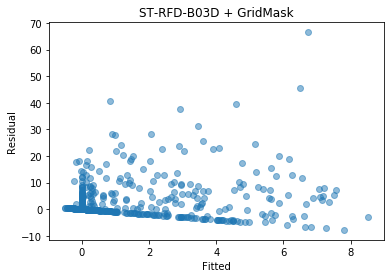

STConvS2S: 2.3110
Explained variance:  -145202535570949.75
r2:  -258533695187569.22
ar2:  0.1178


In [22]:
trainer.path = '../../../models/CHIRPS/5_step/STTSModel_3D_GridMask_MAE_m05d12-h12m34s04.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
batch_explained_variance = 0.0
batch_r2 = 0.0
batch_ar2 = 0.0
model.eval()
y_true = None
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        states = trainer.init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        loss = criterion(output, y)
        y_true = y.cpu().numpy()
        y_pred = output.cpu().numpy()
        if (i == 0):
            plot_residual_fitted(y_true[0,0,0,:,:], y_pred[0,0,0,:,:])
        batch_test_loss += loss.detach().item()
        batch_explained_variance += report_explained_variance(y_true, y_pred)
        r2, ar2 = report_r2(y_true, y_pred)
        batch_r2 += r2
        batch_ar2 += ar2
        
test_loss = batch_test_loss/len(test_loader)
explained_variance = batch_explained_variance/len(test_loader)
r2 = batch_r2/len(test_loader)
ar2 = batch_ar2/len(test_loader)
print(f'STConvS2S: {test_loss:.4f}')
print('Explained variance: ', round(explained_variance,4))
print('r2: ', round(r2,4))
print('ar2: ', round(ar2,4))